# Академия MADE

## Курс "Компьютерное зрение"

## Второй контест по CV: распознавание текстов

## Выполнила: Косарева Екатерина (DS-22)

## За основу решения взята нейронная сеть из семинара по распознаванию автомобильных номеров с помощью CRNN


#### План:
1. Подготовка данных
2. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`)
3. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
4. Обучение модели
5. Предсказание на тестовых данных


## 1.Подготовка данных

#### Загружаем данные с kaggle

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koluzajka","key":"8095ea38c2121995b0fb59d244eaa9ab"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'vk-made-ocr'

 98% 1.06G/1.08G [00:17<00:00, 63.8MB/s]
100% 1.08G/1.08G [00:17<00:00, 66.4MB/s]


In [4]:
!unzip "vk-made-ocr.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/train/955.jpg  
  inflating: /content/data/train/train/9550.jpg  
  inflating: /content/data/train/train/95500.jpg  
  inflating: /content/data/train/train/95501.jpg  
  inflating: /content/data/train/train/95502.jpg  
  inflating: /content/data/train/train/95503.jpg  
  inflating: /content/data/train/train/95504.jpg  
  inflating: /content/data/train/train/95505.jpg  
  inflating: /content/data/train/train/95506.jpg  
  inflating: /content/data/train/train/95507.jpg  
  inflating: /content/data/train/train/95508.jpg  
  inflating: /content/data/train/train/95509.jpg  
  inflating: /content/data/train/train/9551.jpg  
  inflating: /content/data/train/train/95510.jpg  
  inflating: /content/data/train/train/95511.jpg  
  inflating: /content/data/train/train/95512.jpg  
  inflating: /content/data/train/train/95513.jpg  
  inflating: /content/data/train/train/95514.jpg  
  inflating: /content/data/train/tr

### Загружаем библиотеки

In [5]:
import os
import cv2
import tqdm
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

Датасет представляет собой размеченные изображения отрывков текстов.
Формат данных = папка с изображениями + файл train_label.csv, в котором в виде списка хранятся записи о тексте на каждом из изображений.

Узнаем среднюю длинну текста в данных

In [6]:
train = pd.read_csv("/content/data/train_labels.csv")
train['length'] = train['Expected'].apply(lambda x: len(str(x)))
train.describe()

,length
count,276000.000000
mean,7.042033
std,4.271121
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,94.000000


Средняя длина текста равна 7, причем всего 2.5 % данных имеет длину больше 16.

In [7]:
train[train["length"] > 16].shape[0] / train.shape[0]

0.02511231884057971

Создадим конфигурационный список, каждая строка которого будет содержать:

    "file" - путь к изображению
    "text" - текст изображения
    "length" - длина текста

In [8]:
config_full_paths = []
for i in range(train.shape[0]):
    config_full_paths.append({"file": os.path.join("/content/data/train/train", train["Id"].iloc[i]),
                              "text": str(train["Expected"].iloc[i]),
                              "length": train["length"].iloc[i]
                              })
config = config_full_paths

In [9]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 276000
First 3 items:
{'file': '/content/data/train/train/1.jpg', 'text': 'Атырау', 'length': 6}
{'file': '/content/data/train/train/2.jpg', 'text': 'транз', 'length': 5}
{'file': '/content/data/train/train/3.jpg', 'text': 'ходят', 'length': 5}


Посмотрим на данные. В ходе экспериментов было замечено, что в датасете много картинок "перевернутых", посмотрим на них, чтобы понять как лучше трансформировать такие изображения

<ipython-input-10-0d768c3765b9>:23: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


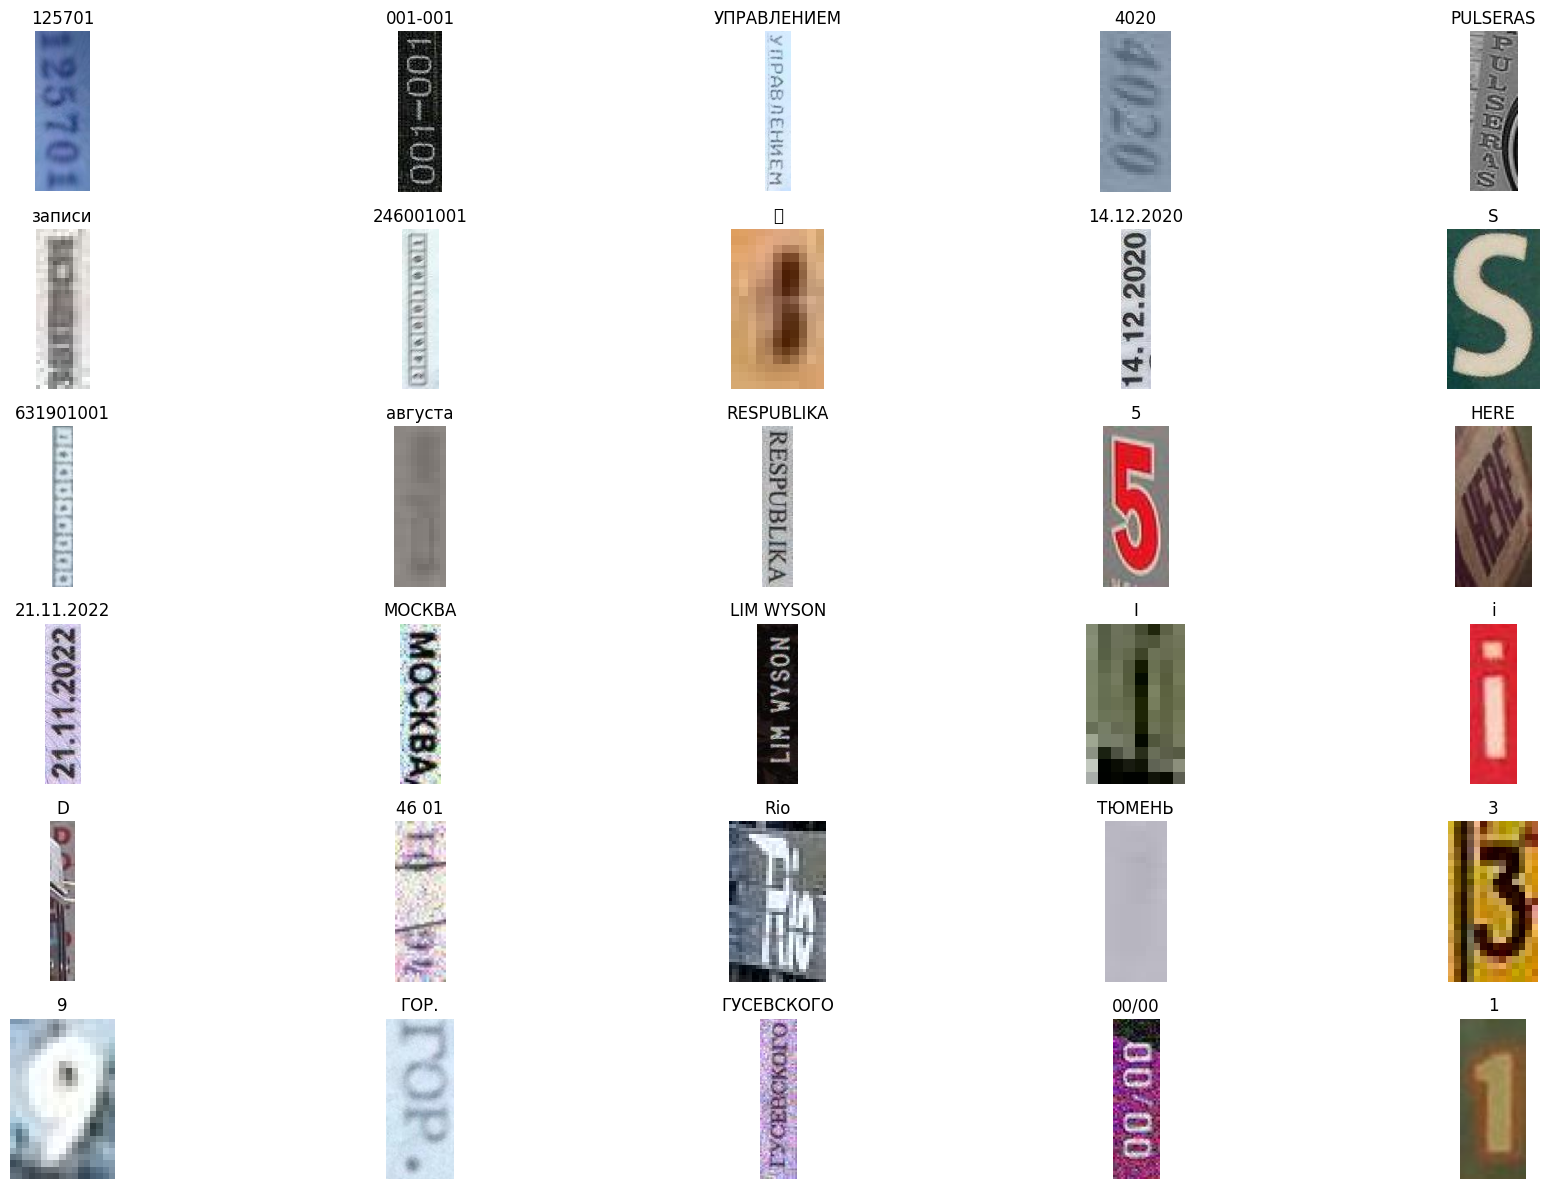

In [10]:
import random
random.seed(4022)
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)
i = 1
# random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
# for i, idx in enumerate(random_idxs, 1):
while i < 31:
    idx = random.randint(0, len(config))
    item = config[idx]
    text = str(item["text"])
    image = cv2.imread(item["file"])
    # print(image.shape)
    if image.shape[0] > 1.5 * image.shape[1]:
      plt.subplot(NUM_ROWS, NUM_COLS, i)
      plt.imshow(image[:, :, ::-1])
      plt.title(text)
      plt.axis("off")
      i += 1

plt.tight_layout()
plt.show()

Как видим многие перевернуты изображения содержат в равной степени текст, который можно читать и сверху вниз и наоборот.

Посмотрим на средний размер изображения.


In [11]:
import random
height = []
width = []
for idx in tqdm.tqdm(range(len(config))):
    item = config[idx]
    text = str(item["text"])
    image = cv2.imread(item["file"])
    # print(image.shape)
    height.append(image.shape[0])
    width.append(image.shape[1])

print(f"Avrage image height={np.mean(height)}, avrage image width = {np.mean(width)}")

100%|██████████| 276000/276000 [01:19<00:00, 3474.44it/s]


Avrage image height=55.704855072463765, avrage image width = 189.95215942028986


Очевидно эти размеры не дают четкого представления к какому размеру приводить изображения, т.к. уже было сказано выше, многие изображения перевернуты, т.е. имеют высоту большую, чем ширину. Поэтому дальше такие изображения мы будем поворачивать на 90 градусов

Посмотрим какие символы встречаются в текстах данных

In [12]:
abc_all = set()

for text in train["Expected"]:
  abc_all.update(set(str(text)))

print(abc_all)



{'à', '！', 'բ', 'ц', 'ε', '》', '；', 'г', 'A', 'ὶ', 'Μ', 'æ', '8', 'v', '時', 'C', '军', 'λ', '人', 'ь', 'д', '택', 'ㄉ', 'Қ', 'ե', 'ν', '์', '훈', '├', 'չ', '秘', 'Θ', 'у', 'н', '宗', 'ส', 'Ο', '└', 'σ', '5', 'ш', '”', 'Ф', 'ξ', 'Ｏ', '北', '→', '維', 'Ν', '貞', 'ã', 'ㄞ', '頭', '′', 'ύ', '森', 'Α', "'", 'ا', '▪', 'в', '桓', 'S', 'q', '道', 'ў', 'С', 'ɔ', '：', 'い', '्', 'ф', '7', 'ت', '石', '法', '煙', '慧', 'Е', 'T', '%', '士', 'ї', '尾', 'Ⅱ', ']', 'χ', 'Щ', 'ง', 'つ', 'ն', 'Ж', 'Д', 'L', 'Н', 'Ц', 'च', '県', '馬', 'ғ', '≤', 'κ', '田', 'Є', 'э', 'y', 'リ', '§', 'พ', '·', 'μ', 'อ', 'á', '만', 'き', 'x', 'R', 'だ', '都', '≠', 'Ι', '‰', '津', 'ら', '音', 'Ｅ', 'Х', '᛫', '＋', '等', 'ی', '鰐', '☆', '０', 'O', '№', 'έ', 'δ', '板', 'Т', '`', 'ק', ';', '岡', 'Φ', 'Ａ', 'Δ', '∼', 'і', 'ヨ', '\u200c', '‘', 'Ы', 'Ƨ', '°', 'К', 'थ', 'श', 'Q', 'a', 'հ', 'と', 'ἰ', '姜', 'υ', '三', '中', 'ก', 'ό', 'ｉ', '８', 'ु', '9', 'ς', '，', '−', 'ê', 'に', 'ө', 'B', '─', '¥', '원', '府', '산', 'm', '¯', '＆', '婓', '魚', 'U', '江', '上', '»', '²', '州', '\xad', '’', '

Оставим только русский и латинский алфавит, а также пунктуацию, все остальные символы выбросим из алфавита

In [13]:
import string
cirilic = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
abc = ''.join([cirilic, cirilic.lower(), string.punctuation,string.ascii_letters,string.digits, ' '])
print(abc)

abc_del = abc_all - set(abc)



АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 


In [14]:
def clean_data(text):
  if len(set(str(text))&abc_del) > 0:
    return False
  return True

clean_idx = [i for i in train.index if clean_data(train["Expected"].loc[i])]


In [15]:
clean_train = train.loc[clean_idx]
clean_train.shape

(268784, 3)

Видим, что число примеров сократилось, но совсем незначительно, менее чем на 8 тысяч, что составляет 2% данных.

Теперь реализуем класса для датасета.

- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)

  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`.
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).


In [16]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        text = str(self.texts[item])
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """

        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE

        return seq

В качестве трансформации будем использовать поворот изображения против часовой стрелки, если высота изображения превышает ширину в 3 раза, и ресайз к фиксированному размеру `(320, 64)`.


In [17]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.

        Args:
            - item: Dict with keys "image", "seq", "seq_len", "text".

        Returns:
            Dict with image resized to self.size.
        """

        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        if item["image"].shape[0] > 3*item["image"].shape[1]:
          item["image"] = cv2.rotate(item["image"], cv2.ROTATE_90_COUNTERCLOCKWISE)
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        # END OF YOUR CODE

        return item

Соберем датасет вместе:

In [18]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

Посмотрим на пример

In [23]:
x = dataset[105]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


Image shape: (64, 320, 3)
Seq: [58, 13, 68, 50, 0, 24, 72, 29, 155] Seq_len: 9
Text: чЛ"п«Ц&Ы4


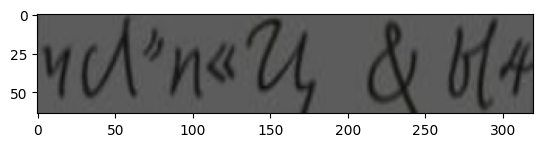

In [24]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

Текст изображения может иметь любую длину, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.


In [25]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [26]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [27]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([ 1, 53, 62, 51, 34, 54, 53, 51, 34, 48, 42, 56, 49, 38, 66, 53, 49, 60,
        54, 60, 39, 48, 43, 44, 78], dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


### 2. Построение модели CRNN-like

Модель `feature_extractor` используем предобученную модель `ResNet18` в качестве basemodel, без последних двух слоев (это `AdaptiveAvgPool2d` и `Linear`). После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`.

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами, которые могут быть даже длиннее). Во-первых, мы выбросим данные с текстом длинее 16, так как по статистики их всего 2%. Затем применим сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`. `output_len` сделаем в несколько раз больше, чкм максимальная длинна max_len текста в нашем датасете.

In [28]:
max_len = 16
max_output_len = 48

class FeatureExtractor(Module):

    def __init__(self, input_size=(64, 320), output_len=max_output_len):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [29]:
feature_extractor = FeatureExtractor(input_size=(64, 320))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.0MB/s]


In [30]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, max_output_len)

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `ResNet18`, т.е. 512),
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`.

`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности.


In [31]:
class SequencePredictor(Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE

        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """

        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE

        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [32]:
sequence_predictor = SequencePredictor(input_size=512,
                                       hidden_size=128,
                                       num_layers=2,
                                       num_classes=len(abc)  + 1)

In [33]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [35]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 162)

---

Теперь соберем две части в один класс CRNN.

In [36]:
HEIGHT = 64
WIDTH = 320

INPUT_SIZE = (HEIGHT, WIDTH)

class CRNN(Module):

    def __init__(self, alphabet=abc,
                 cnn_input_size=INPUT_SIZE, cnn_output_len=max_output_len,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [37]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [39]:
crnn = CRNN()

In [41]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (max_output_len, 1, 162)

In [42]:
decode(y, abc)

['y5yВjКCЦTКjXyKЪчnКЦ3dXGKNj5$К$YjXo']

### 3. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`,

* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 4. Обучение модели

In [43]:
ACTUALLY_TRAIN = False

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [44]:
crnn = CRNN()

Зададим гиперпараметры обучения:

In [45]:
num_epochs = 10
batch_size = 128
num_workers = 4

In [46]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [47]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [48]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [49]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True,
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Запустим обучение (при параметрах по умолчанию эпоха занимает ~9 минут на GPU):
В качестве метрики точности будем мониторить ctcloss и среднее расстояние Левинштейна, которое возьмем из пакета nltk

In [50]:
from nltk import edit_distance

In [51]:
# num_epochs = 3
patience = 5
crnn.train()
if not ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []
        epoch_metric = []
        crnn.train()
        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt.cpu(),  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt.cpu(),
                            zero_infinity=True)  # N
            # print(log_probs, seqs_gt)
            # print(loss)
            texts_preds = decode(seqs_pred, abc)
            res = 0
            for text_pred, text_real in zip(texts_preds, b['text']):
                res += edit_distance(text_pred, text_real)
            epoch_metric.append(res / len(texts_preds))
            # print(texts_preds)
            # print(res / len(texts_preds))
            # break

            optimizer.zero_grad()
            loss.backward()
            # clip here
            torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1.0) # or some other value

            optimizer.step()

            epoch_losses.append(loss.item())

        print(f"Epoch :{i}, loss: {np.mean(epoch_losses)}, levenstein: {np.mean(epoch_metric)}")

        val_losses = []
        val_dist = []
        crnn.eval()
        for j, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):

            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            with torch.no_grad():
                seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt.cpu(),  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt.cpu(),
                        zero_infinity=True)  # N

            val_losses.append(loss.item())

            texts_preds = decode(seqs_pred, abc)
            res = 0
            for text_pred, text_real in zip(texts_preds, b['text']):
                res += edit_distance(text_pred, text_real)
            val_dist.append(res / len(texts_preds))

        print(f"Epoch :{i}, val_loss: {np.mean(val_losses)}, val_levenstein: {np.mean(val_dist)}")

        if i > 4 and min(val_losses[-patience:]) >= val_losses[-patience - 1]:
          break



  0%|          | 0/1725 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1725/1725 [08:01<00:00,  3.58it/s]


Epoch :0, loss: 4.218201494769773, levenstein: 6.473138586956522


100%|██████████| 432/432 [01:13<00:00,  5.90it/s]


Epoch :0, val_loss: 3.3158162081683122, val_levenstein: 5.758915653935185


100%|██████████| 1725/1725 [08:38<00:00,  3.33it/s]


Epoch :1, loss: 2.797348242773526, levenstein: 4.928129528985507


100%|██████████| 432/432 [01:14<00:00,  5.77it/s]


Epoch :1, val_loss: 2.194907873592995, val_levenstein: 4.006799768518518


100%|██████████| 1725/1725 [08:15<00:00,  3.48it/s]


Epoch :2, loss: 1.9305649242539338, levenstein: 3.5469791666666666


100%|██████████| 432/432 [01:08<00:00,  6.29it/s]


Epoch :2, val_loss: 1.705931818595639, val_levenstein: 3.1800853587962963


100%|██████████| 1725/1725 [08:29<00:00,  3.39it/s]


Epoch :3, loss: 1.5272796451181605, levenstein: 2.8963088768115943


100%|██████████| 432/432 [01:13<00:00,  5.84it/s]


Epoch :3, val_loss: 1.4435646636066612, val_levenstein: 2.722782841435185


100%|██████████| 1725/1725 [07:49<00:00,  3.67it/s]


Epoch :4, loss: 1.316291716893514, levenstein: 2.5531748188405796


100%|██████████| 432/432 [01:01<00:00,  6.99it/s]


Epoch :4, val_loss: 1.3424645745091968, val_levenstein: 2.532081886574074


100%|██████████| 1725/1725 [07:43<00:00,  3.72it/s]


Epoch :5, loss: 1.1867191463968028, levenstein: 2.3446150362318843


100%|██████████| 432/432 [01:05<00:00,  6.59it/s]

Epoch :5, val_loss: 1.265714124534969, val_levenstein: 2.4013129340277777


Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

  0%|          | 0/432 [00:01<?, ?it/s]


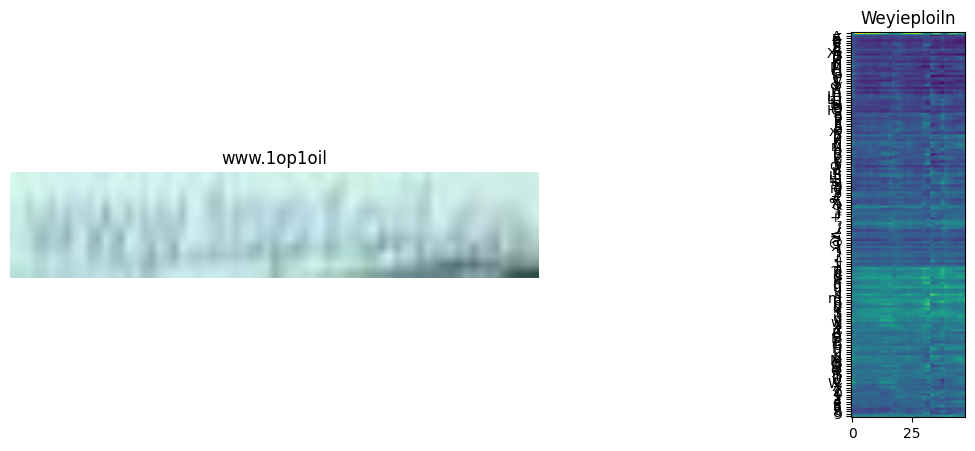

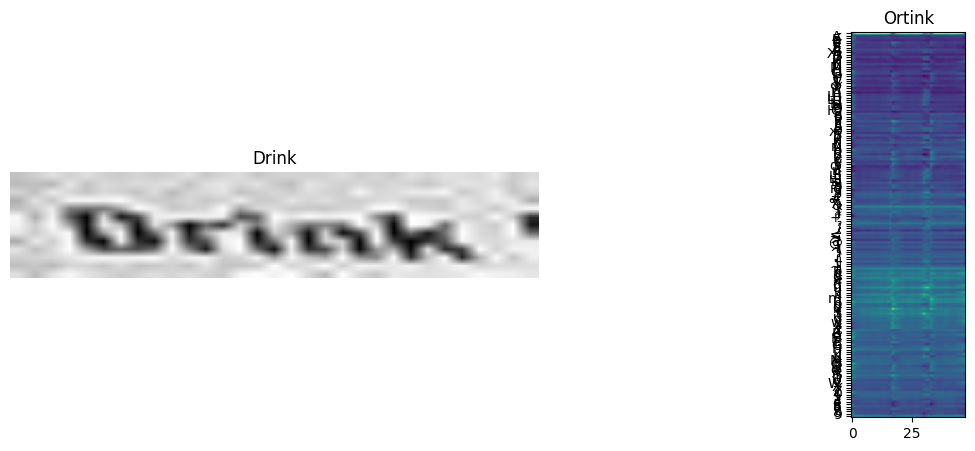

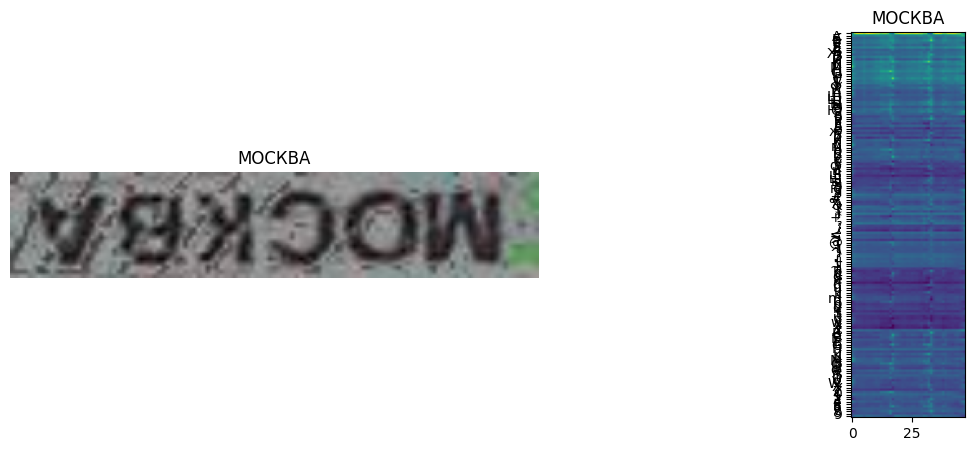

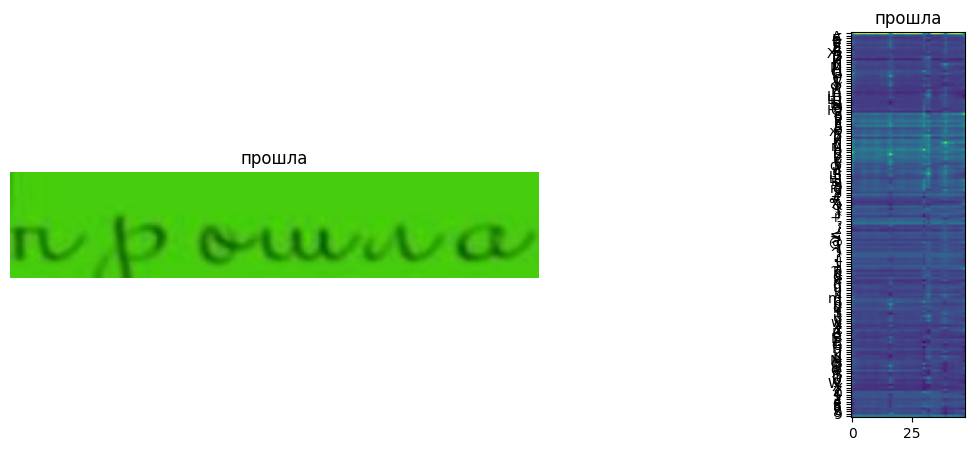

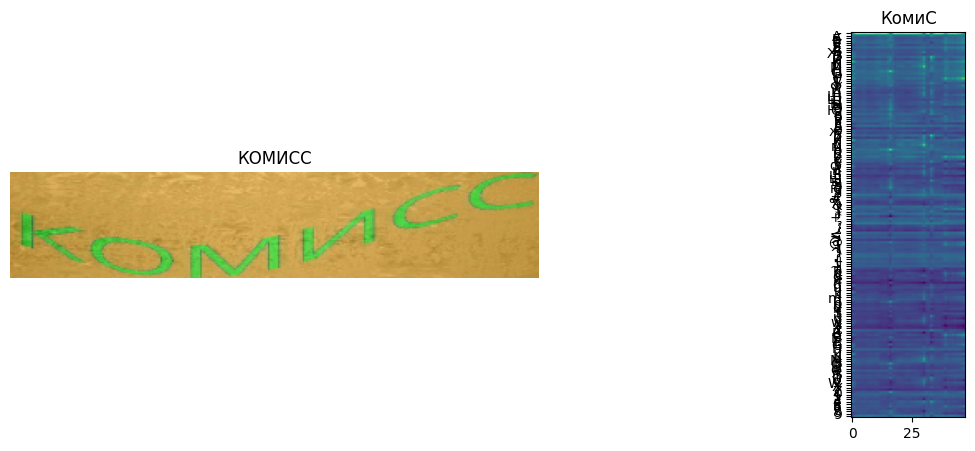

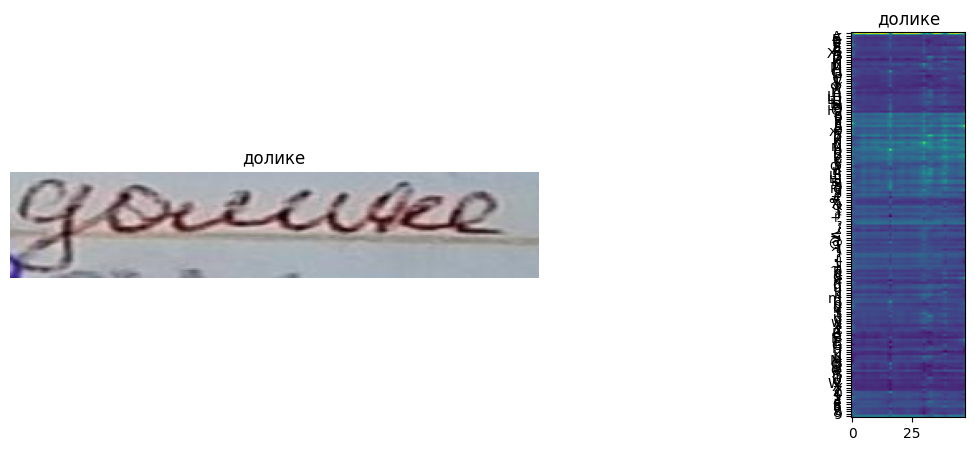

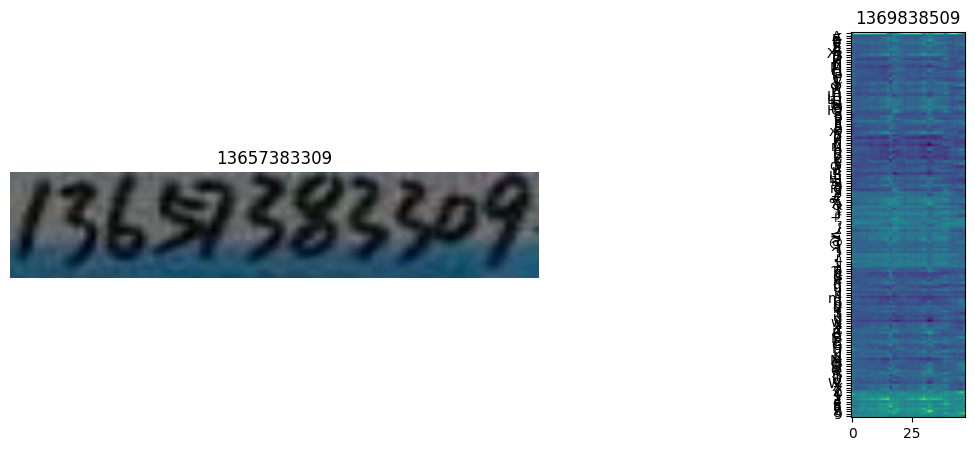

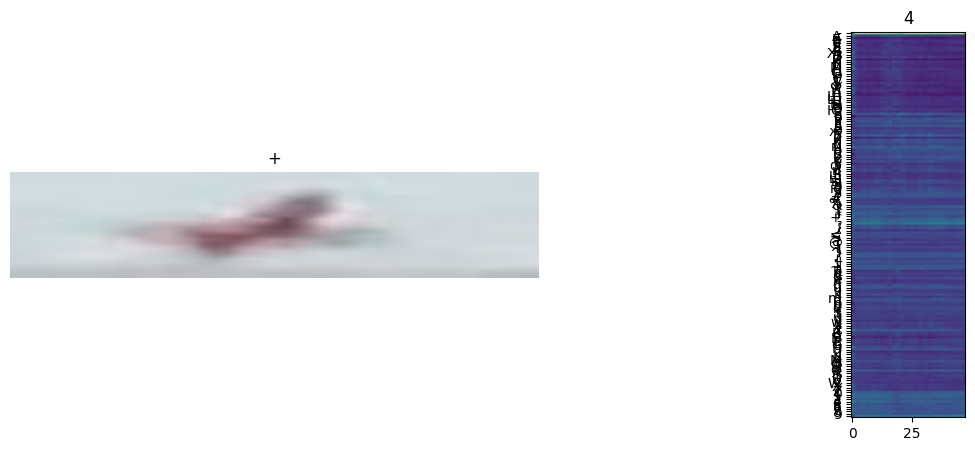

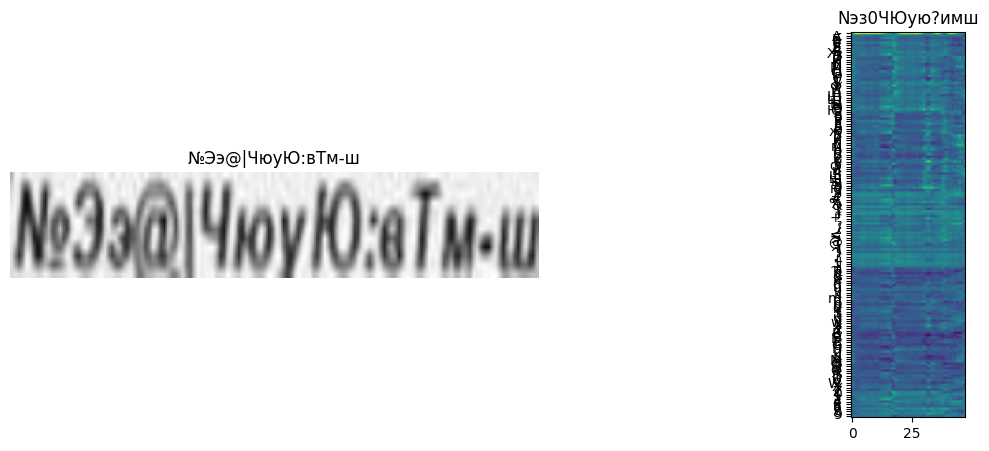

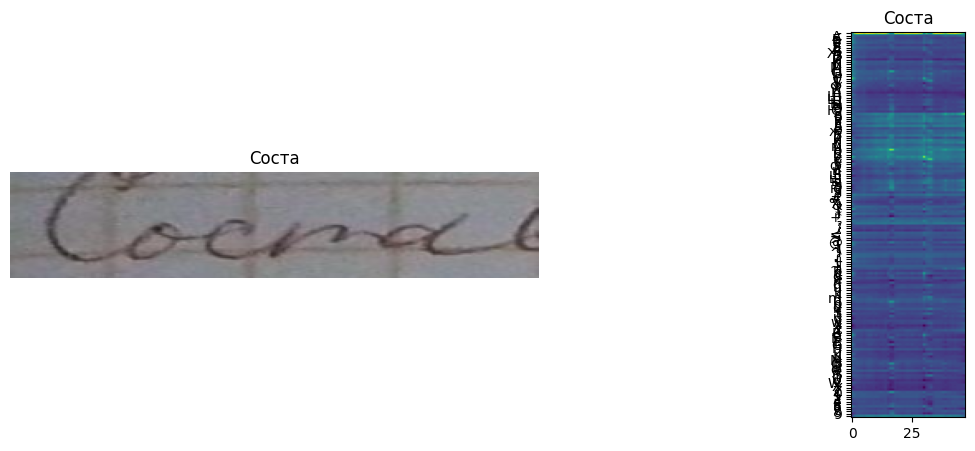

In [ ]:
for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
    break
crnn.eval()
if not ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts[i])

        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title(texts_pred[i])

        plt.show()
else:
    for i in range(1, 11):

        image_val_log = cv2.imread(f"./resources/{str(i).zfill(2)}.png")
        plt.figure(figsize=(15, 8))
        plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
        plt.axis("off")
        plt.show()

Видим, что даже для перевернутого вверх ногами текста мы получили правильное предсказание

##5. Получим предсказания на тестовых данных

In [ ]:
class TestDataset(Dataset):
    """Class for prediction image-to-text mapping using CTC-Loss."""

    def __init__(self, root, path, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(TestDataset, self).__init__()
        self.path = path
        self.root = root
        self.alphabet = alphabet
        self.image_names = os.listdir(self.path)
        self.transforms = transforms

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(os.path.join(self.root, self.image_names[item])).astype(np.float32) / 255.
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        output = dict(image=image)
        if self.transforms is not None:
            output = self.transforms(output)
        return output


In [ ]:
def collate_ts(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images = []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
    images = torch.stack(images)
    batch = {"image": images}
    return batch

In [ ]:
test_path = "/content/data/test/test/"
test_dataset = TestDataset("/content/data/test/test",test_path, transforms=Resize())
test_dataloader = DataLoader(test_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_ts)

In [ ]:
crnn.eval()
pred_text = []
for i, b in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    images = b["image"]
    with torch.no_grad():
        preds = crnn(images.to(device)).cpu().detach()
    pred_text += decode(preds, crnn.alphabet)

submit = pd.DataFrame()
submit["Id"] = os.listdir(test_path)
submit["Predicted"] = pred_text



100%|██████████| 415/415 [00:52<00:00,  7.83it/s]


In [ ]:
submit.head()

,Id,Predicted
0,47887.jpg,-ПТы
1,14134.jpg,К0д
2,11645.jpg,Зальназаалсксе
3,35005.jpg,KN
4,34777.jpg,Aproximatery


In [ ]:
submit.to_csv("/content/submition_03.csv", index=False)

from google.colab import files
files.download("/content/submition_03.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(crnn.state_dict(), "/content/model_v3.pt")
files.download("/content/model_v3.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>